## Delay dataframe insights : 

- The delay_at_checkout_in_minutes and time_delta_with_previous_rental_in_minutes don't seem correlated.
- Although most values ​​are zero, there are large outliers in both directions for delays at checkout. For negative values we can make the assumptions that it's because the person arrived early at checkout.
- For checkins by mobile, there are much longer delays than for checkins by connect. Actually , for connect checkin , the median of the distribution is even negative.
- More than half of the drivers are late for the checkout.

## Pricing dataframe insights :
- The brands with the highest mean rental price per day are , in decreasing order , Suzuki , Mini , and Lexus.
- The brands with the lowest mean rental price per day are , in decreasing order , Peugeot , Fiat , and Mazda.
- The most correlated numerical variables with the rental price per day are  , in descreasing order , the engine power , the mileage , and the fact that a car is automatic or not.

## New feature analysis insights :
- For a maximum of 24 hour minimum delay between two rentals, we can expect to lose 7% of transactions overall , almost 15% for connect checkin types and only 5% for mobile checkins.
- Based on the previous fact , I think that we should only implement the feature for mobile checkin types. We can also take into account the fact that there is way less late checkout for connect checkin than mobile ones (with a median of -9 minutes for connect and 14 minutes of delay for mobile).
- The optimal threshold for the feature , in my opinion , would be 110 minutes. I computed this values based on the ratio between the number of solved frictions versus the number of created problems for a given minimum delay.

In [127]:
##### Imports #####

# Data manipulation and viz
import pandas as pd , numpy as np
import matplotlib.pyplot as plt , seaborn as sns , missingno as msno

# Statistics
from scipy.stats import ttest_ind_from_stats  , mannwhitneyu

import warnings 
warnings.filterwarnings('ignore')

In [128]:
##### Constants #####

alpha = 0.05 # Significance level
thresholds = list(range(10 , 730 , 10))  # 730 is the equivalent of 12 hours
df = pd.read_excel('get_around_delay_analysis.xlsx')
df_copy = df.copy()
df_doc = pd.read_excel('get_around_delay_analysis.xlsx', sheet_name='Documentation')
df_pricing = pd.read_csv('get_around_pricing_project.csv' , index_col='Unnamed: 0')

In [129]:
##### Functions #####

def ecdf(data : np.array):
    '''Return the Empirical Cumulative Distribution Function'''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1 , n+1) / n 
    return x , y



def check_correlation(target : str , df : pd.DataFrame , method : str):
    '''Returns a sorted dataframe with the columns names and their correlation with 
    the specified target variable'''
   
    cor = [df[target].corr(df[col] , method=method) for col in df.columns]
    dictio = dict(zip(df.columns , cor))

    to_ret = pd.DataFrame({'columns' : dictio.keys()  , 'correlation_with_the_specified_target' : dictio.values()})\
    .sort_values(by=['correlation_with_the_specified_target'] , ascending=False)[1:]

    to_ret['abs_correlation'] = abs(to_ret['correlation_with_the_specified_target']) 
    return to_ret.sort_values(by='abs_correlation' , ascending=False).drop('abs_correlation' , axis=1)




def thresholds_simulation(df : pd.DataFrame):
    # Here we make the hypothesis (because the data description is not perfectly clear about it) that we are talking about the same temporality of location for delay checkout and time delta
    df['delta'] = df['time_delta_with_previous_rental_in_minutes'] - df['delay_at_checkout_in_minutes']
    df['delta'] = df['delta'].fillna(0)
    friction = df[df['delta'] < 0]


    # Problem created by the threshold (same approach as before)
    to_plot_created , to_plot_solved = {} , {}
    for thresh in thresholds:
        to_plot_created[thresh] = len(df_copy[df_copy['time_delta_with_previous_rental_in_minutes'] <= thresh])


        # Subset for the cases where the time delta would be smaller or equal to the threshold
        diffs_friction = friction[friction['time_delta_with_previous_rental_in_minutes'] <= thresh] # Because only in this case it would make a change


        # Count the cases where time_delta was smaller than threshold AND the threshold fixed the late checkout problem
        counter = 0
        for i in range(len(diffs_friction)):
            subset = diffs_friction.iloc[i]

            # If the threshold fixed the late checkout problem
            if subset['delta'] + thresh >= 0:
                counter += 1 # Increment the number of case solved for that threshold

        # The number of time that the threshold solved a problem
        to_plot_solved[thresh] = counter

    return to_plot_created , to_plot_solved



def compare_lines(created : dict , solved : dict , title : str , best_threshold_value : int):

    # At this point maybe check the logic again , and create a ratio between solved / created , then plot it overall , for connect and mobile
    plt.figure(figsize=(15,7))
    plt.plot(created.keys() , created.values() , label='Problem created by the threshold' , color='red')
    plt.plot(solved.keys() , solved.values() , label='Problem solved by the threshold' , color='blue')
    plt.xlabel('Minimum delay between rentals')
    plt.ylabel('Number of rental impacted')
    plt.legend()
    plt.title(f'Rental lost versus saved by differents threshold values {title}')
    plt.show()



    ratio = dict(zip(list(created.keys()) , np.array(list(solved.values()))  /  np.array(list(created.values()))))
    plt.figure(figsize=(15,7))
    plt.plot(ratio.keys() , ratio.values() , color='purple')
    plt.ylabel('Ratio number of problem solved vs created')
    plt.xlabel('Minimum delay between rentals')
    plt.axvline(best_threshold_value , color='grey' , linestyle='--' , alpha=0.7 , label=f'Best threshold : {best_threshold_value} minutes')
    plt.title(f'Ratio between the number of problem solved vs created by the feature for different values {title}')
    plt.legend()
    plt.show()

## EDA delays

In [130]:
df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [131]:
with pd.option_context('display.max_colwidth', None):
  display(df_doc)

,field name,Comment
0,rental_id,Unique identifier of the rental
1,car_id,Unique identifier of the car
2,checkin_type,"Flow used for both checkin and checkout. (ie. access and return the car)\nmobile = rental agreement signed on the owner's smartphone\nconnect = car equiped with the Connect technology , opened by the driver with his smartphone.\nNote: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case"
3,state,canceled means that the rental did not happen (was canceled by the driver or the owner).
4,delay_at_checkout_in_minutes,Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
5,previous_ended_rental_id,id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
6,time_delta_with_previous_rental_in_minutes,"Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)"


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


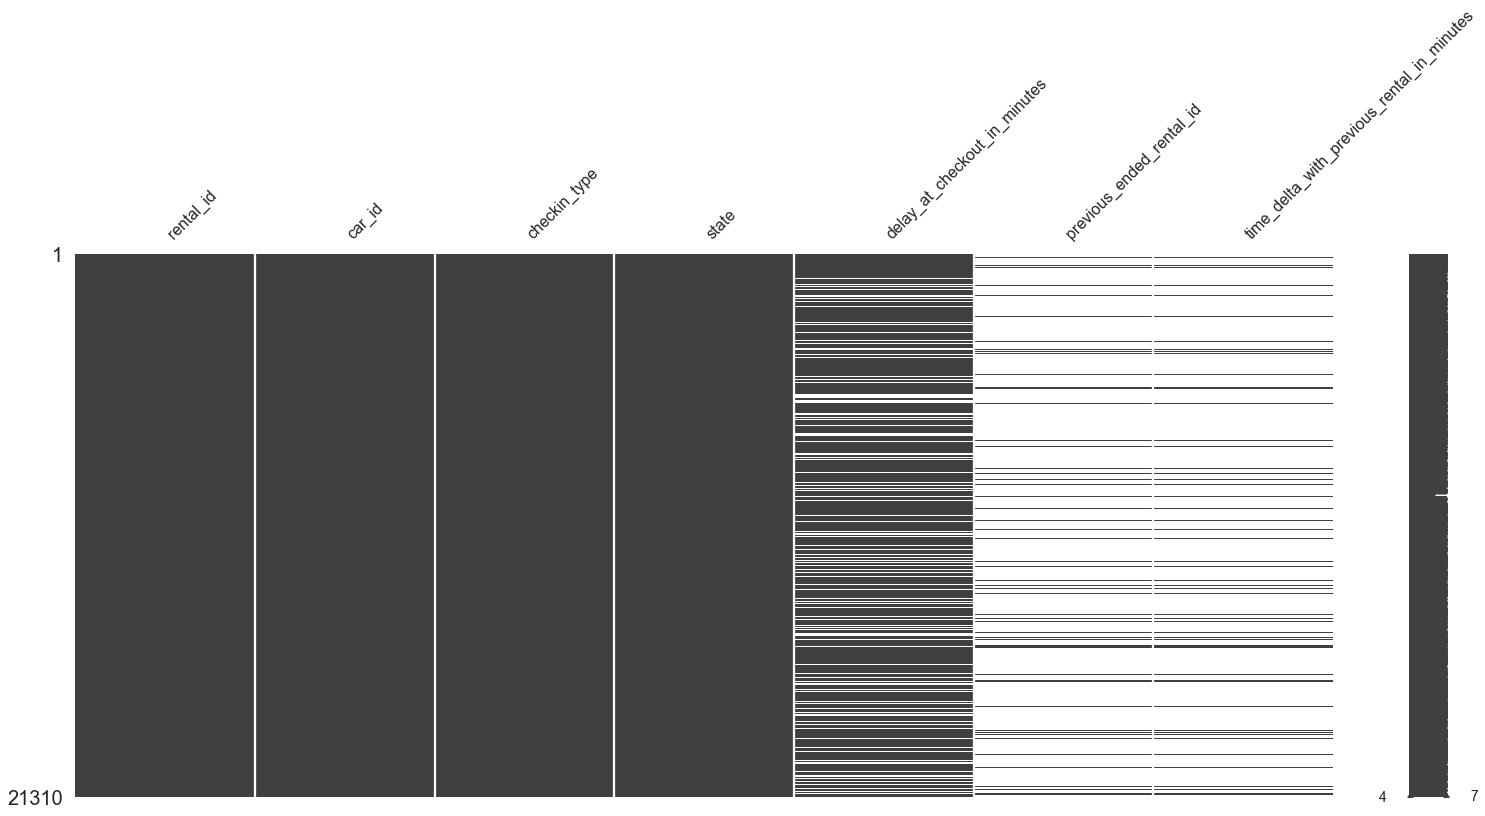

In [133]:
# Null values
msno.matrix(df)
plt.show()

In [134]:
# Unuseful and almost all null
df = df.drop('previous_ended_rental_id' , axis=1 , errors='ignore')

# Since I am mostly interested in those two variables , I will keep only the rows where both variables are completes
to_keep = df[['delay_at_checkout_in_minutes']].dropna().index #  , 'time_delta_with_previous_rental_in_minutes'
df = df[df.index.isin(to_keep)].reset_index(drop=True)

In [135]:
print('Unique checkin types : ' , df['checkin_type'].unique())

Unique checkin types :  ['mobile' 'connect']


In [136]:
print('Unique state : ' , df['state'].unique())

Unique state :  ['ended' 'canceled']


In [137]:
print(df['delay_at_checkout_in_minutes'].describe() , '\n')
print(df['time_delta_with_previous_rental_in_minutes'].describe() , '\n')

count    16346.000000
mean        59.701517
std       1002.561635
min     -22433.000000
25%        -36.000000
50%          9.000000
75%         67.000000
max      71084.000000
Name: delay_at_checkout_in_minutes, dtype: float64 

count    1515.000000
mean      276.871287
std       254.865947
min         0.000000
25%        60.000000
50%       180.000000
75%       540.000000
max       720.000000
Name: time_delta_with_previous_rental_in_minutes, dtype: float64 



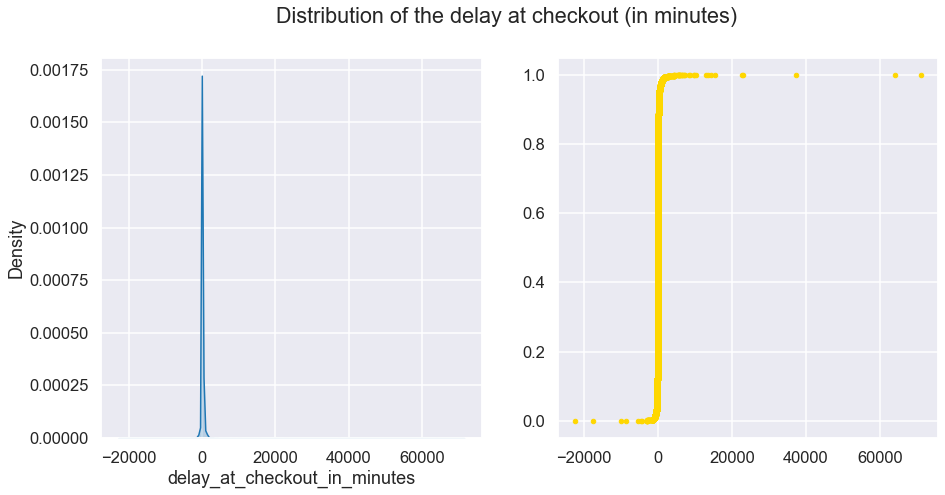

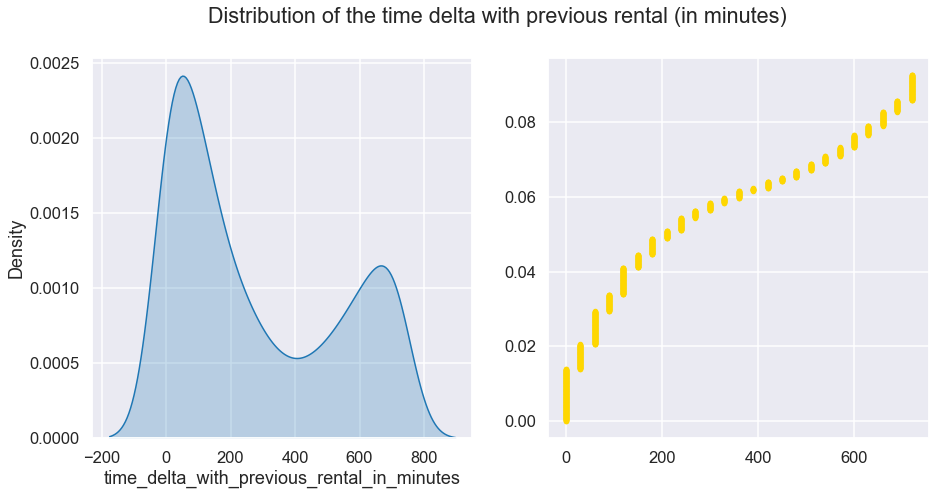

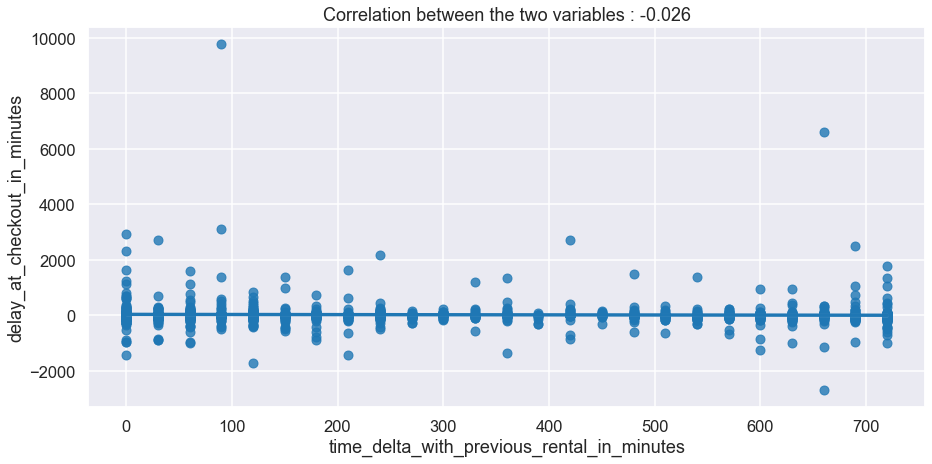

In [138]:
sns.set_style('darkgrid')
sns.set_context('talk')

fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(15,7))
x , y = ecdf(df['delay_at_checkout_in_minutes'].values)
sns.kdeplot(df['delay_at_checkout_in_minutes'], fill=True , ax=ax1)
ax2.plot(x , y , marker='.' , linestyle='none' , color='gold')
fig.suptitle('Distribution of the delay at checkout (in minutes)')
plt.show()


fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(15,7))
x , y = ecdf(df['time_delta_with_previous_rental_in_minutes'].values)
sns.kdeplot(df['time_delta_with_previous_rental_in_minutes'], fill=True , ax=ax1)
ax2.plot(x , y , marker='.' , linestyle='none' , color='gold')
fig.suptitle('Distribution of the time delta with previous rental (in minutes)')
plt.show()


plt.figure(figsize=(15,7))
corr_ = round(df['delay_at_checkout_in_minutes'].corr(df['time_delta_with_previous_rental_in_minutes']),3)
sns.regplot(data=df , x='time_delta_with_previous_rental_in_minutes' , y='delay_at_checkout_in_minutes')
plt.title(f'Correlation between the two variables : {corr_}')
plt.show()

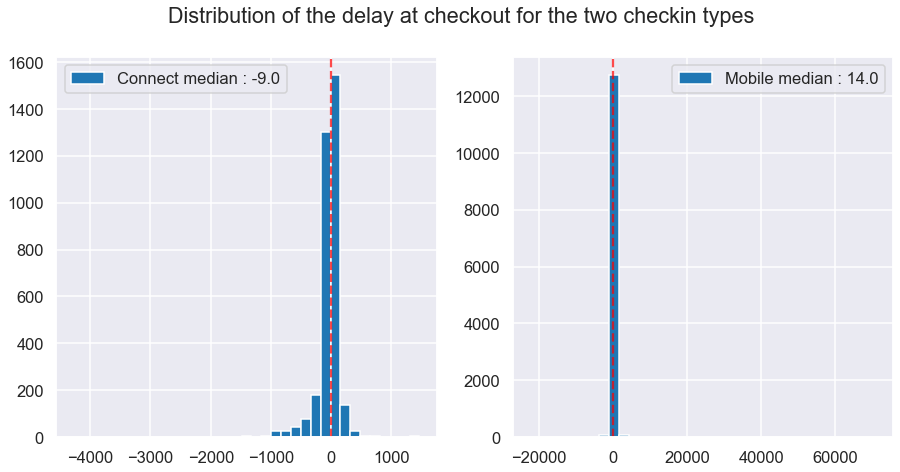

The two array have statistically differents means.


In [139]:
connect_sub = df[df['checkin_type'] == 'connect']
mobile_sub = df[df['checkin_type'] == 'mobile']


fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(15,7))
median_connect = round(np.median(connect_sub['delay_at_checkout_in_minutes']), 2)
median_mobile = round(np.median(mobile_sub['delay_at_checkout_in_minutes']) , 2)
ax1.hist(connect_sub['delay_at_checkout_in_minutes'] , bins=35 , label=f'Connect median : {median_connect}')
ax1.axvline(median_connect , linestyle='--' , color='red' , alpha=0.7)
ax1.legend()

ax2.hist(mobile_sub['delay_at_checkout_in_minutes'] , bins=35 , label=f'Mobile median : {median_mobile}')
ax2.axvline(median_mobile , linestyle='--' , color='red' , alpha=0.7)
ax2.legend()


fig.suptitle('Distribution of the delay at checkout for the two checkin types')
plt.show()

# Statistical test
pval = ttest_ind_from_stats(mean1=connect_sub['delay_at_checkout_in_minutes'].mean() , mean2=mobile_sub['delay_at_checkout_in_minutes'].mean() ,
                     std1=connect_sub['delay_at_checkout_in_minutes'].std() , std2=mobile_sub['delay_at_checkout_in_minutes'].std(),
                     nobs1=len(connect_sub) , nobs2=len(mobile_sub) ,
                     alternative='two-sided' , equal_var=False)[1]

if pval <= alpha:
    print('The two array have statistically differents means.')
else:
    print('There is no evidences that the two array have statistically differents means.')

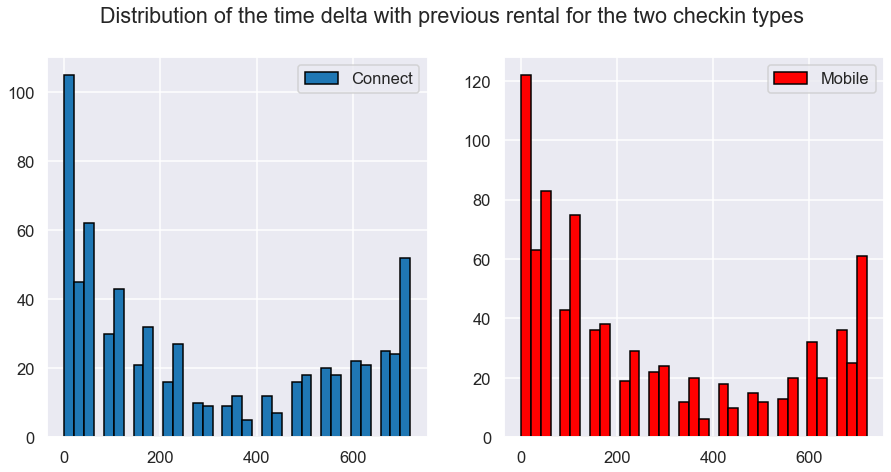

There is no statisticals evidences that the two arrays have differents distributions.


In [140]:
fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(15,7))
median_connect = round(np.median(connect_sub['time_delta_with_previous_rental_in_minutes']), 2)
median_mobile = round(np.median(mobile_sub['time_delta_with_previous_rental_in_minutes']) , 2)
ax1.hist(connect_sub['time_delta_with_previous_rental_in_minutes'] , bins=35 , label='Connect', edgecolor='black')
ax2.hist(mobile_sub['time_delta_with_previous_rental_in_minutes'] , bins=35 , label='Mobile' , color='red' , edgecolor='black')
ax1.legend()
ax2.legend()

fig.suptitle('Distribution of the time delta with previous rental for the two checkin types')
plt.show()

pval = mannwhitneyu(mobile_sub['time_delta_with_previous_rental_in_minutes'] , connect_sub['time_delta_with_previous_rental_in_minutes'])[1]

if pval <= alpha:
    print('There is statisticals evidences that the two arrays have differents distributions.')
else:
    print('There is no statisticals evidences that the two arrays have differents distributions.')

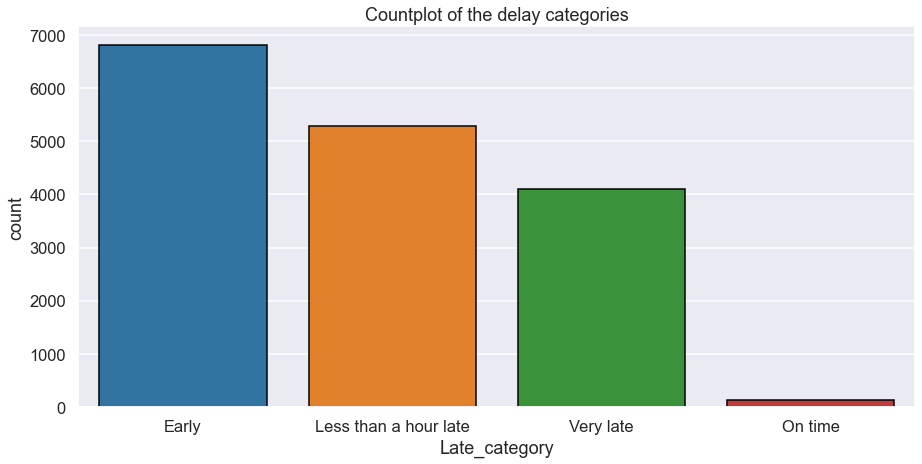

In [141]:
quantile_75 = df['delay_at_checkout_in_minutes'].quantile(0.75)
# print(quantile_75)

late_category = []
for delay in df['delay_at_checkout_in_minutes']:
    if delay == 0:
        late_category.append('On time')
    elif delay < 0:
        late_category.append('Early')
    elif 0 < delay < quantile_75:
        late_category.append('Less than a hour late')
    else:
        late_category.append('Very late')

df['Late'] = [1 if delay > 0 else 0 for delay in df['delay_at_checkout_in_minutes']]
df['Late_category'] = late_category

plt.figure(figsize=(15,7))
sns.countplot(df['Late_category'] , edgecolor='black' , order=['Early'  , 'Less than a hour late' , 'Very late' , 'On time'])
plt.title('Countplot of the delay categories')
plt.show()

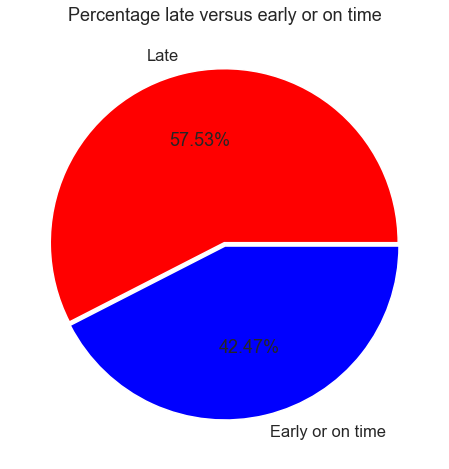

In [142]:
labels = ['Late' , 'Early or on time']
values_ = [len(df[df['Late'] == 1]) , len(df[df['Late'] == 0])]
plt.figure(figsize=(10,8))
plt.pie(x=values_ , labels=labels  , explode=(0.01,0.01) , autopct='%1.2f%%' , colors=['red' , 'blue'])
plt.title('Percentage late versus early or on time')
plt.show()

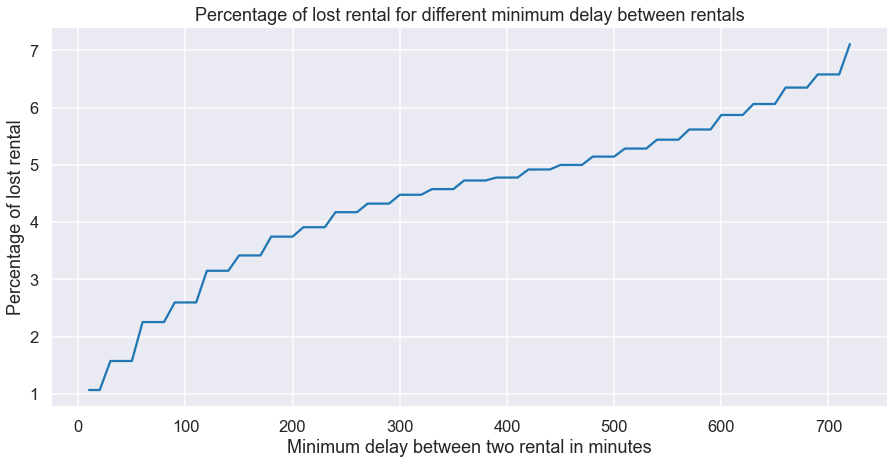

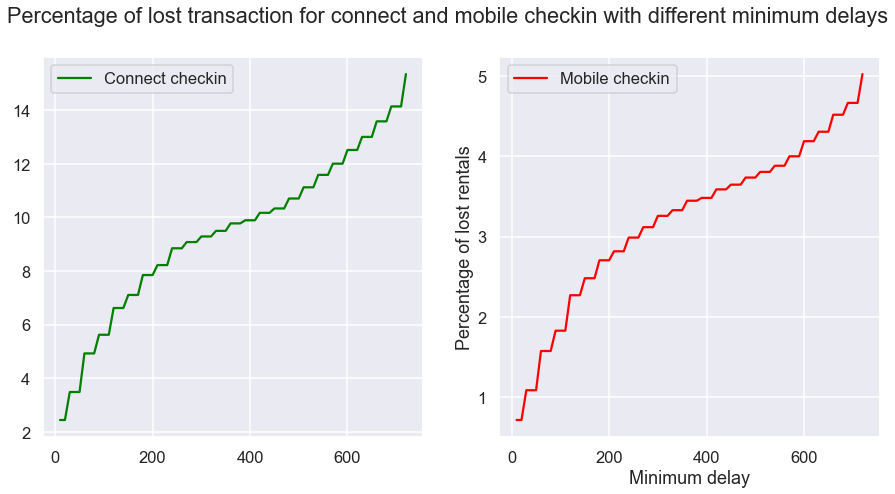

In [143]:
# Testing the number of lost rental with different threshold
delay_min = {}
subset = df[['time_delta_with_previous_rental_in_minutes']].dropna()

to_plot = {}
for thresh in thresholds:
    to_plot[thresh] =  len(subset[subset['time_delta_with_previous_rental_in_minutes'] <= thresh]) / len(df_copy) * 100


plt.figure(figsize=(15,7))
plt.plot(to_plot.keys() , to_plot.values())
plt.ylabel('Percentage of lost rental')
plt.xlabel('Minimum delay between two rental in minutes')
plt.title('Percentage of lost rental for different minimum delay between rentals')
plt.show()



fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(15,7))
subset_mobile = mobile_sub[['time_delta_with_previous_rental_in_minutes']].dropna()
subset_connect = connect_sub[['time_delta_with_previous_rental_in_minutes']].dropna()

to_plot_connect = {}
for thresh in thresholds:
    to_plot_connect[thresh] =  len(subset_connect[subset_connect['time_delta_with_previous_rental_in_minutes'] <= thresh]) / len(df_copy[df_copy['checkin_type'] == 'connect']) * 100

to_plot_mobile = {}
for thresh in thresholds:
    to_plot_mobile[thresh] =  len(subset_mobile[subset_mobile['time_delta_with_previous_rental_in_minutes'] <= thresh]) / len(df_copy[df_copy['checkin_type'] == 'mobile']) * 100

ax1.plot(to_plot_connect.keys() , to_plot_connect.values() , color='green' , label='Connect checkin')
ax2.plot(to_plot_mobile.keys() , to_plot_mobile.values() , color='red' , label='Mobile checkin')

ax1.legend()
ax2.legend()

plt.ylabel('Percentage of lost rentals')
plt.xlabel('Minimum delay')

fig.suptitle('Percentage of lost transaction for connect and mobile checkin with different minimum delays')
plt.show()

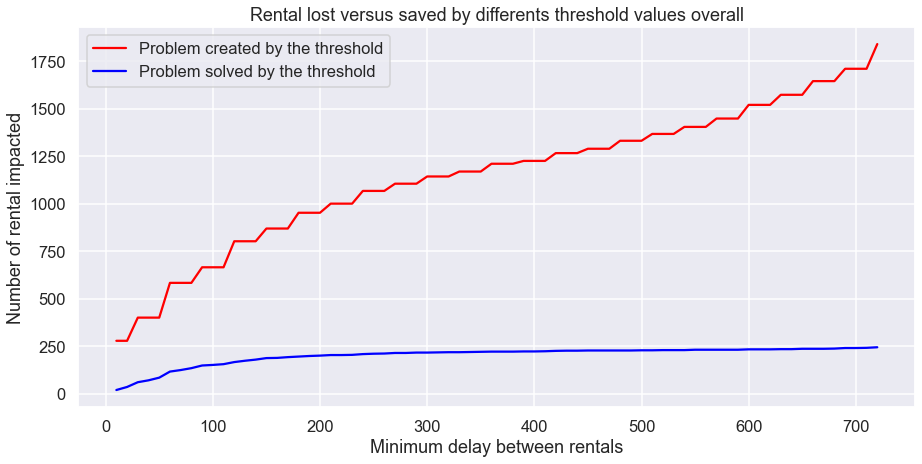

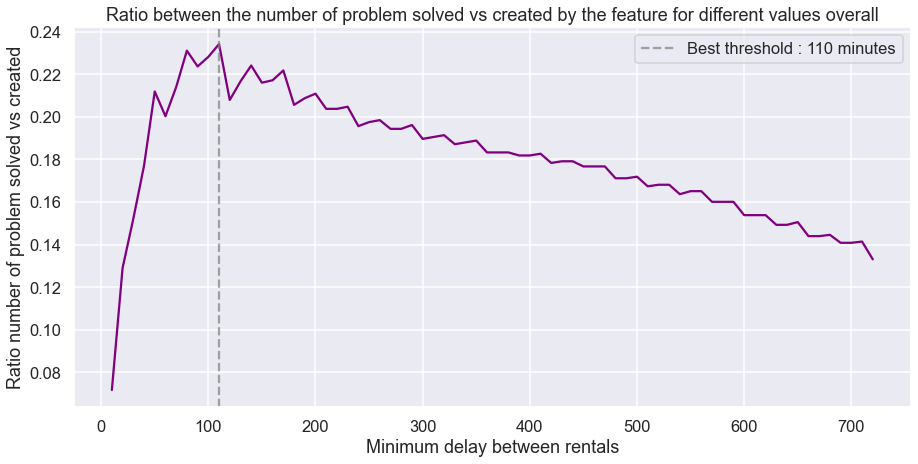

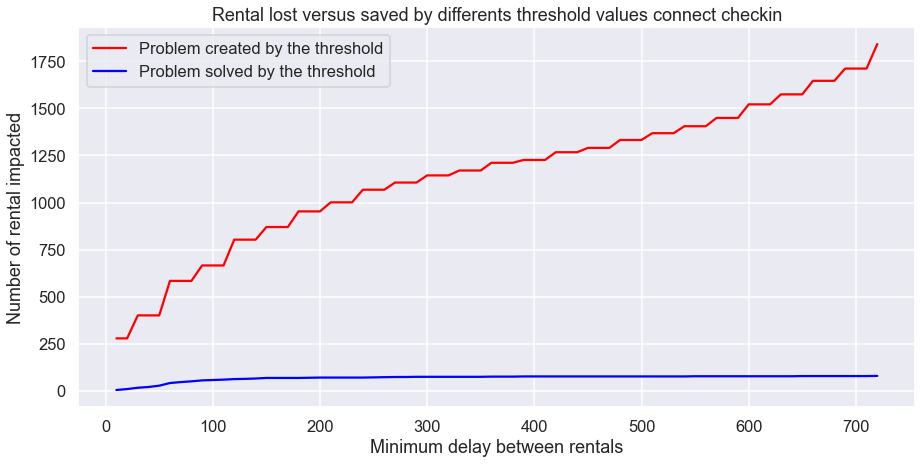

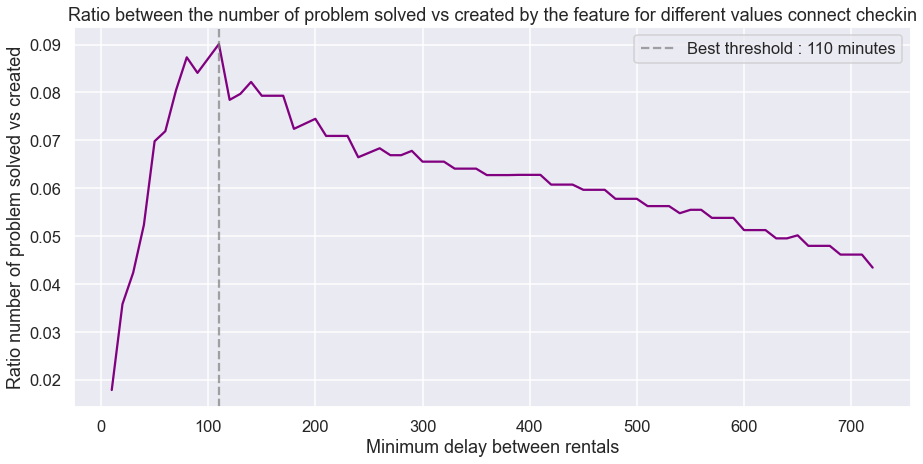

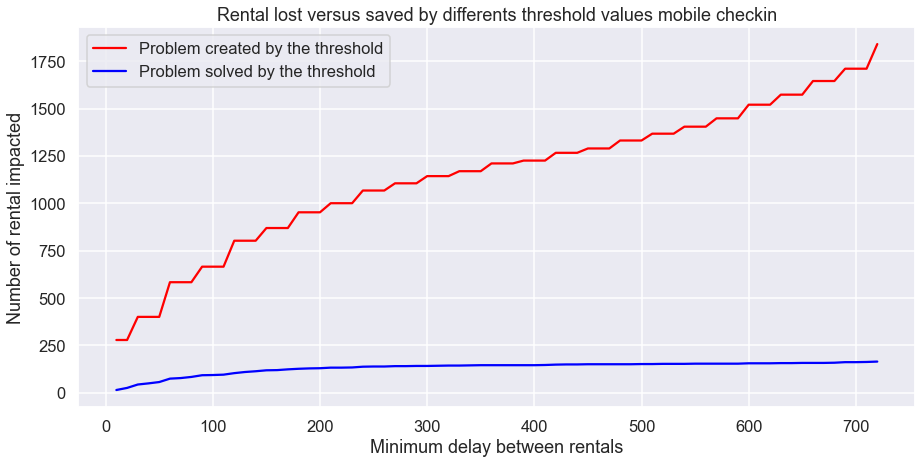

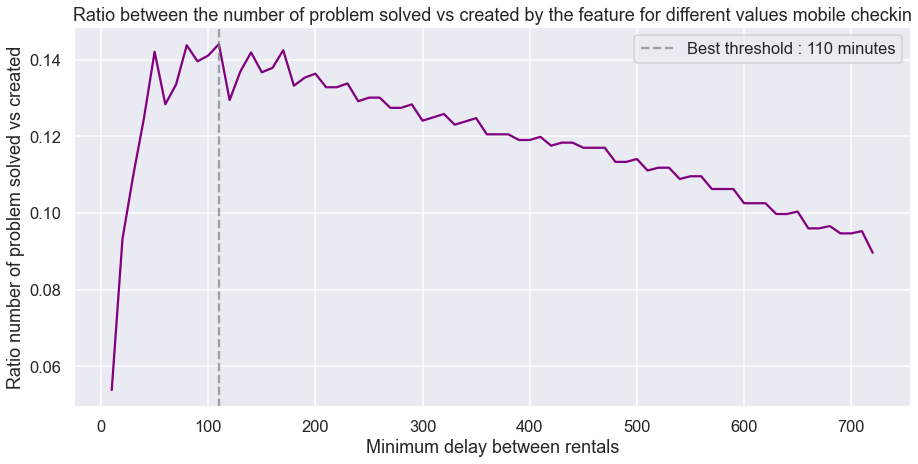

In [144]:
created_overall , solved_overall = thresholds_simulation(df=df)
created_connect , solved_connect = thresholds_simulation(df=df[df['checkin_type'] == 'connect'])
created_mobile , solved_mobile = thresholds_simulation(df=df[df['checkin_type'] == 'mobile'])


compare_lines(created=created_overall , solved=solved_overall , title='overall' , best_threshold_value=110)
print('\n\n')
compare_lines(created=created_connect , solved=solved_connect , title='connect checkin' , best_threshold_value=110)
print('\n\n')
compare_lines(created=created_mobile, solved=solved_mobile , title='mobile checkin' , best_threshold_value=110)

## EDA pricing

In [145]:
df_pricing.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [146]:
df_pricing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4843 non-null   object
 1   mileage                    4843 non-null   int64 
 2   engine_power               4843 non-null   int64 
 3   fuel                       4843 non-null   object
 4   paint_color                4843 non-null   object
 5   car_type                   4843 non-null   object
 6   private_parking_available  4843 non-null   bool  
 7   has_gps                    4843 non-null   bool  
 8   has_air_conditioning       4843 non-null   bool  
 9   automatic_car              4843 non-null   bool  
 10  has_getaround_connect      4843 non-null   bool  
 11  has_speed_regulator        4843 non-null   bool  
 12  winter_tires               4843 non-null   bool  
 13  rental_price_per_day       4843 non-null   int64 
dtypes: bool(

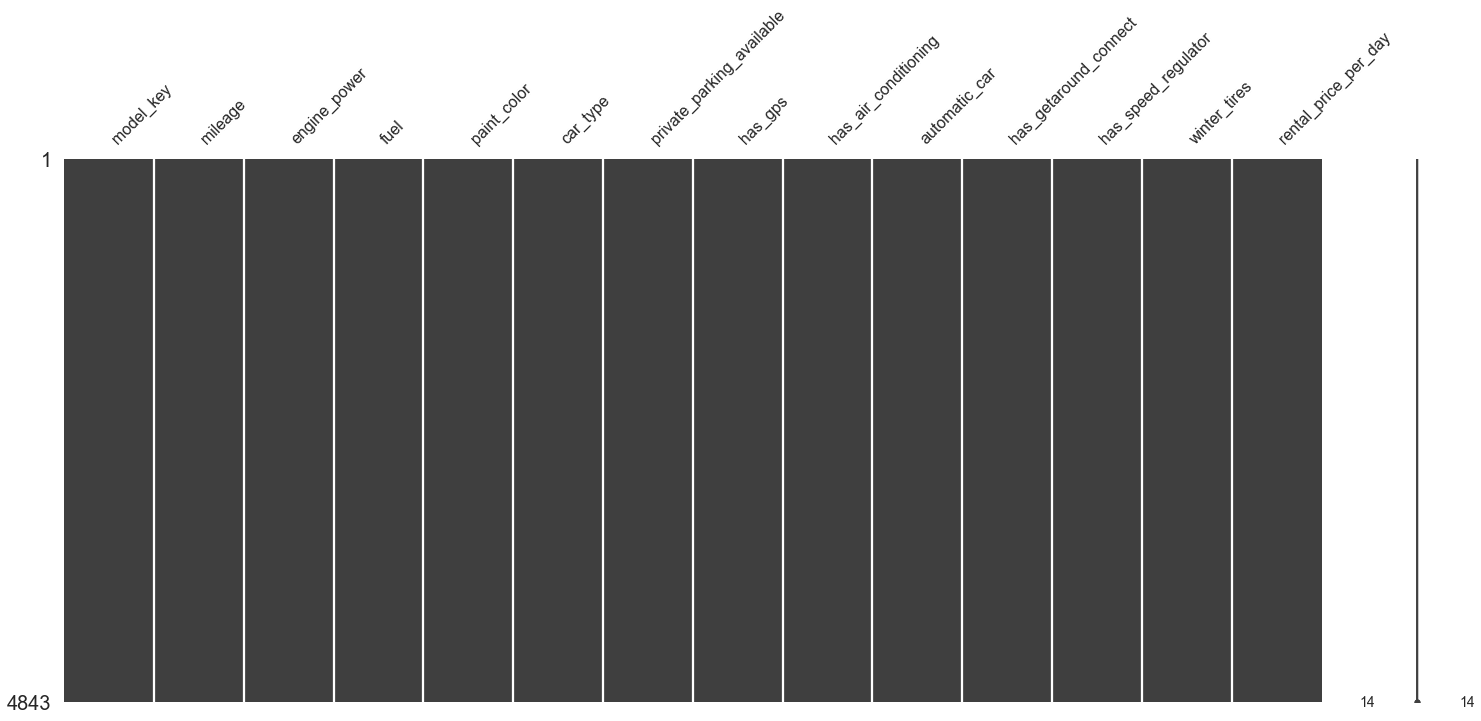

In [147]:
msno.matrix(df_pricing) # Null values
plt.show() # Wonderful !

In [148]:
print('Unique model keys : ' , df_pricing['model_key'].unique())

Unique model keys :  ['Citroën' 'Peugeot' 'PGO' 'Renault' 'Audi' 'BMW' 'Ford' 'Mercedes' 'Opel'
 'Porsche' 'Volkswagen' 'KIA Motors' 'Alfa Romeo' 'Ferrari' 'Fiat'
 'Lamborghini' 'Maserati' 'Lexus' 'Honda' 'Mazda' 'Mini' 'Mitsubishi'
 'Nissan' 'SEAT' 'Subaru' 'Suzuki' 'Toyota' 'Yamaha']


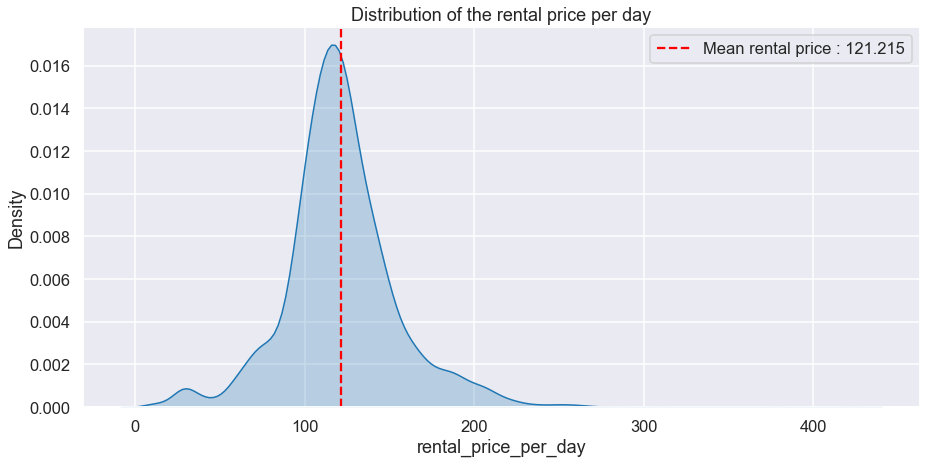

In [149]:
mean_price_per_day = round(df_pricing['rental_price_per_day'].mean(), 3)
plt.figure(figsize=(15,7))
sns.kdeplot(df_pricing['rental_price_per_day'] , fill=True)
plt.axvline(mean_price_per_day , color='red' , linestyle='--' , label=f'Mean rental price : {mean_price_per_day}')
plt.legend()
plt.title('Distribution of the rental price per day')
plt.show()

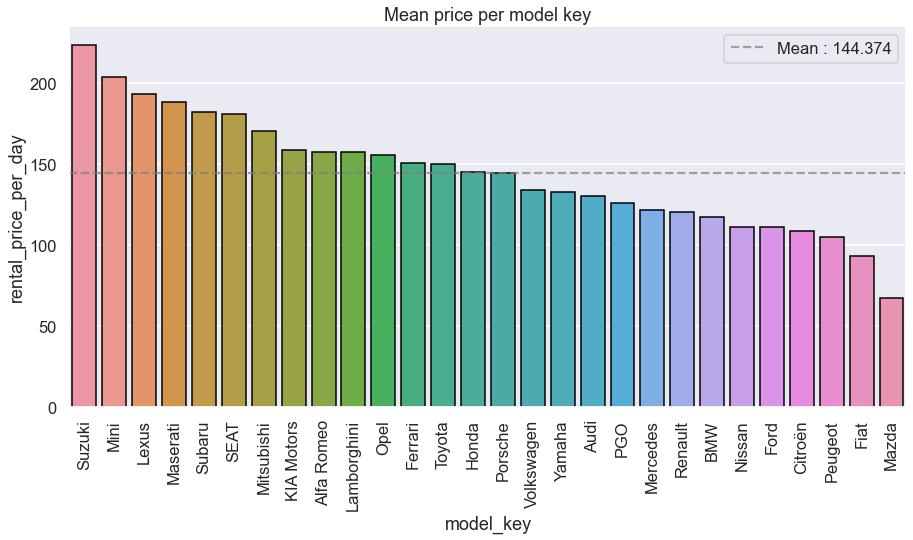

In [150]:
to_plot = df_pricing.groupby('model_key' , as_index=False)['rental_price_per_day'].mean().sort_values(by='rental_price_per_day' , ascending=False)
mean_ = round(to_plot['rental_price_per_day'].mean() , 3)

plt.figure(figsize=(15,7))
sns.barplot(data=to_plot , x='model_key' , y='rental_price_per_day' , edgecolor='black')
plt.axhline(mean_ , color='grey' , alpha=0.7 , linestyle='--' , label=f'Mean : {mean_}')
plt.title('Mean price per model key')
plt.legend()
plt.xticks(rotation=90)
plt.show()

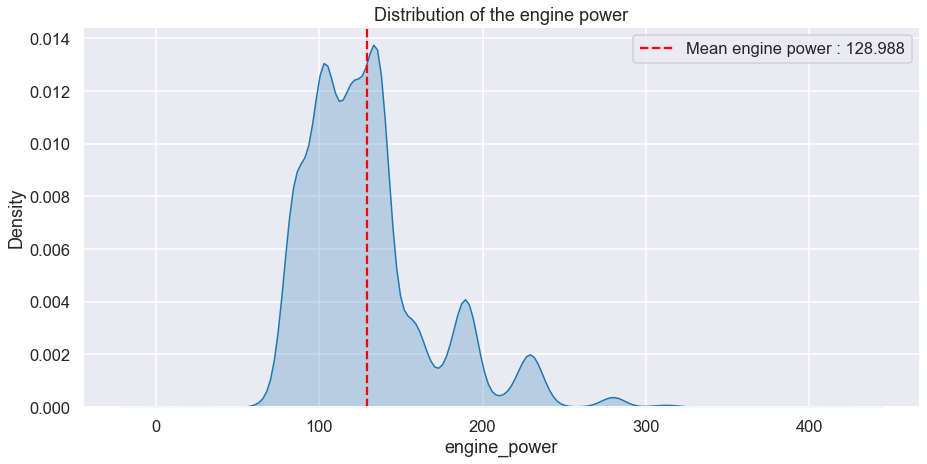

In [151]:
mean_engine_power = round(df_pricing['engine_power'].mean(), 3)
plt.figure(figsize=(15,7))
sns.kdeplot(df_pricing['engine_power'] , fill=True)
plt.axvline(mean_engine_power , color='red' , linestyle='--' , label=f'Mean engine power : {mean_engine_power}')
plt.legend()
plt.title('Distribution of the engine power')
plt.show()

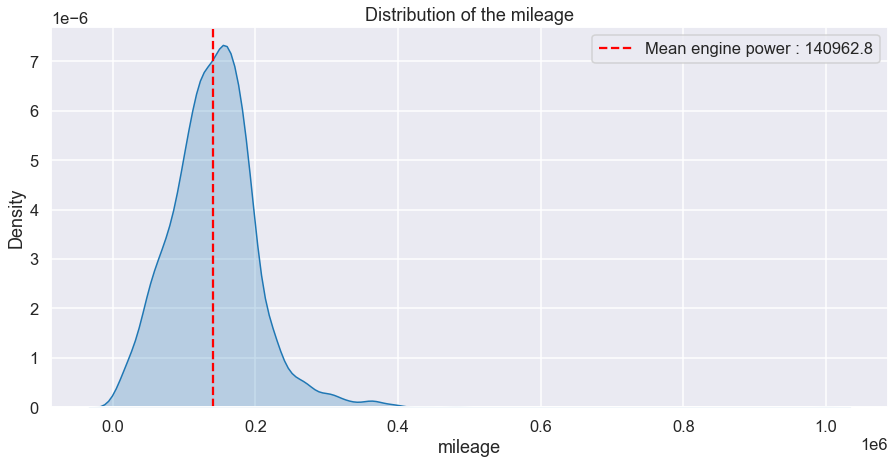

In [152]:
mean_mileage = round(df_pricing['mileage'].mean(), 3)
plt.figure(figsize=(15,7))
sns.kdeplot(df_pricing['mileage'] , fill=True)
plt.axvline(mean_mileage , color='red' , linestyle='--' , label=f'Mean engine power : {mean_mileage}')
plt.legend()
plt.title('Distribution of the mileage')
plt.show()

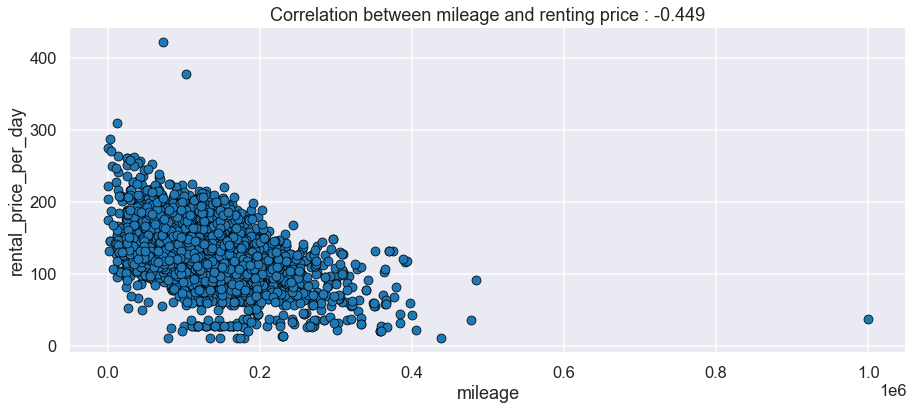

In [153]:
plt.figure(figsize=(15,6))
corr_ = round(df_pricing['mileage'].corr(df_pricing['rental_price_per_day']) , 3)
sns.scatterplot(data=df_pricing , x='mileage' , y='rental_price_per_day' , edgecolor='black')
plt.title(f'Correlation between mileage and renting price : {corr_}')
plt.show()

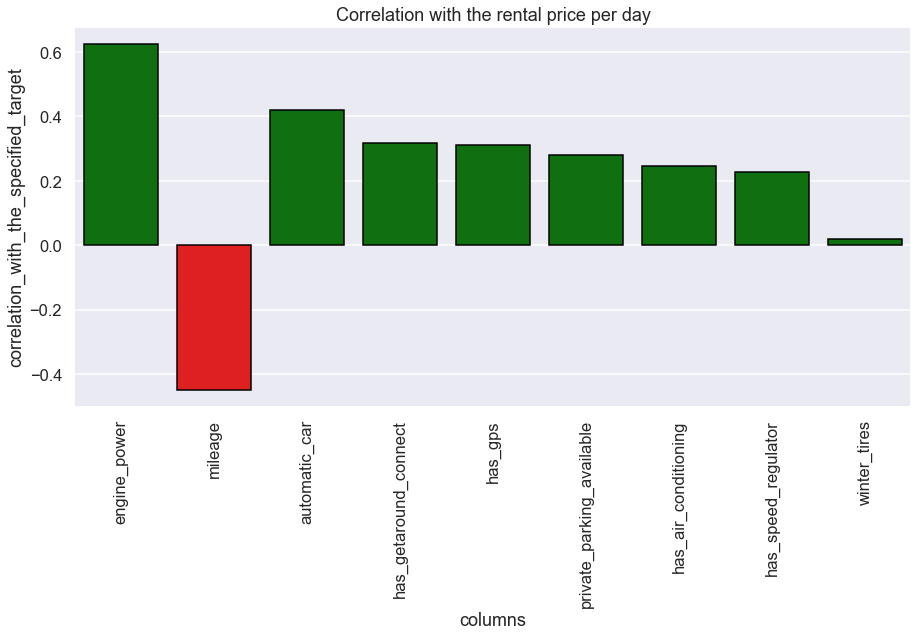

In [154]:
corr_df = df_pricing.drop(['fuel',	'paint_color',	'car_type' , 'model_key'] , axis=1)
corrs_ = check_correlation(target='rental_price_per_day' , df=corr_df , method='pearson')


plt.figure(figsize=(15,7))
sns.barplot(data=corrs_ , x='columns' , y='correlation_with_the_specified_target' , edgecolor='black' , palette= ['green' if corr >= 0 else 'red' for corr in corrs_['correlation_with_the_specified_target']])
plt.title('Correlation with the rental price per day')
plt.xticks(rotation=90)
plt.show()